
**Good Seed Supermarket - Computer Vision-Based System**
---

### Introduction
---
This project develops a computer vision-based age estimation system for Good Seed, a supermarket chain, to assist in complying with alcohol sales regulations. The system leverages image analysis from checkout cameras to provide a preliminary age estimate.

Observation after model training indicated that the mean absolute error (MAE) decreased with increasing epochs for both training and testing sets. Average loss reached approximately 7 years, implying that age estimation from a checkout camera image may deviate by an average of 7 years.

Such accuracy aids Good Seed in preventing alcohol sales to underage individuals by providing a preliminary age estimate to prevent alcohol sales to underage individualsan. 

### Importing Libraries
---

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings

In [ ]:
warnings.filterwarnings("ignore")

### Importing Dataset
---

Found 10 validated image filenames.


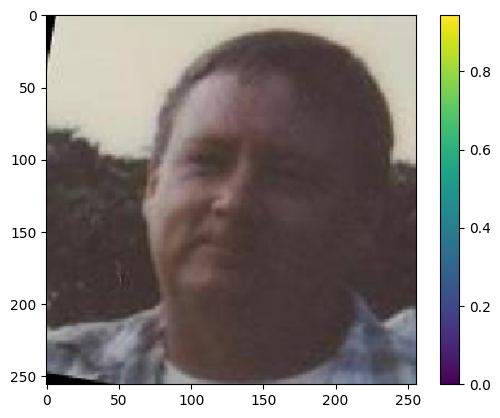

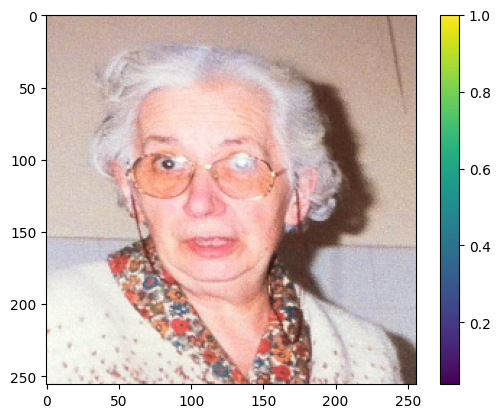

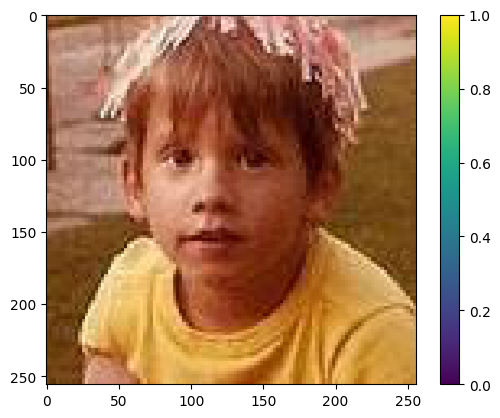

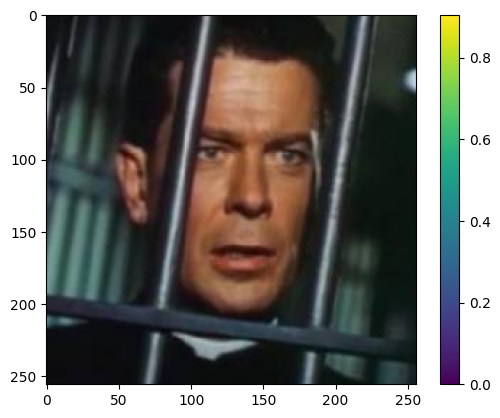

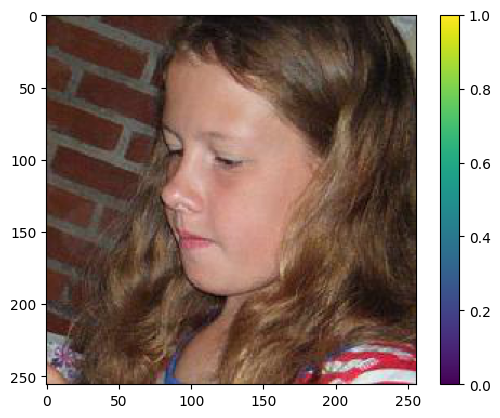

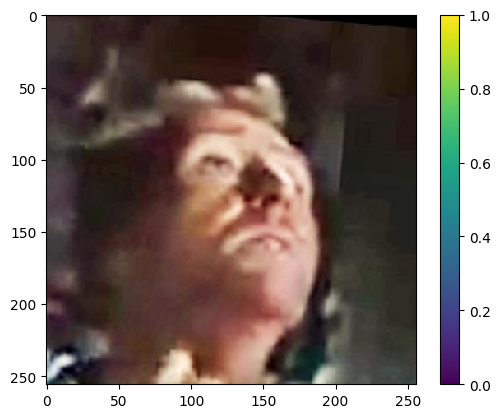

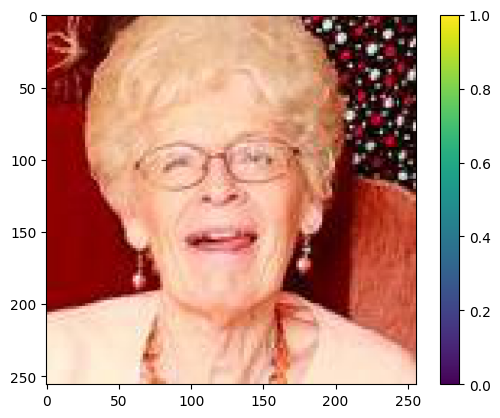

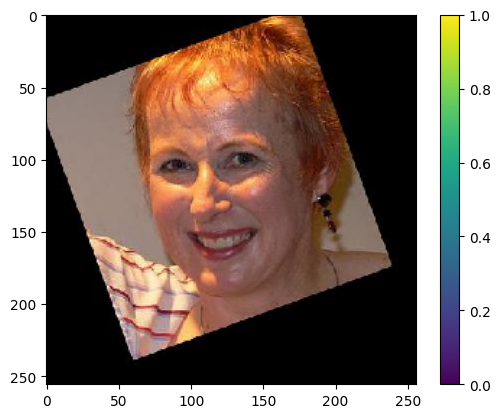

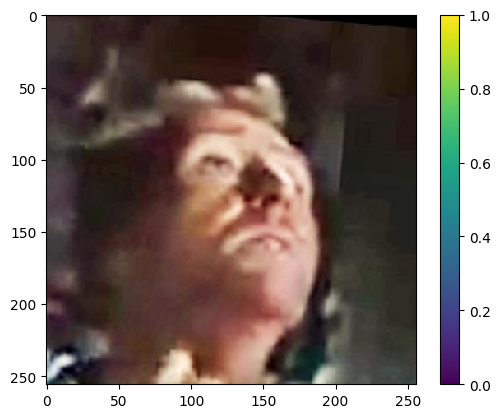

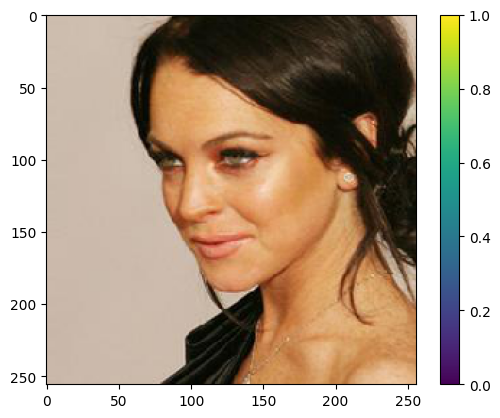

In [2]:
#Building the ImageDataGenerator generator to print 10 photos
files = ["007609.jpg", "007611.jpg", "000002.jpg", "000003.jpg",
         "000000.jpg", "007612.jpg", "007612.jpg", "003484.jpg", 
         "006707.jpg", "006999.jpg"]

data_frame = pd.DataFrame({'images': files})
image_directory = '/datasets/faces/final_files/' 

datagen = ImageDataGenerator(rescale=1/255)
data_flow = datagen.flow_from_dataframe(dataframe = data_frame, directory=image_directory, 
                                        x_col='images',y_col=None, 
                                        batch_size=10, 
                                        class_mode=None, seed=None)


images_batch = next(data_flow)

for i in range(10):
    plt.figure()
    plt.imshow(images_batch[i])
    plt.colorbar()
    plt.show()

In [3]:
#Loading the labels file
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Exploratory Data Analysis (EDA)
---

In [5]:
labels['real_age'].isna().sum()


0

In [6]:
(labels['real_age']=='').sum()

0

In [7]:
labels.duplicated().sum()

0

In [8]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [10]:
count_older = (labels['real_age']>70).sum()
print(f"{count_older / len(labels) * 100:.2f}%")

2.53%


### Findings
---

- ***Labels file:*** The labels file comprises 7,600 images with filenames organized by age. Analysis with the describe function reveals an average age of 31 years (median 29) and a standard deviation of 17 years, with an even age distribution; although some outliers exceed 70 years, these outliers account for only 2.5% of the dataset, resulting in a negligible impact on image processing analysis. The dataset provides sufficient diversity for feature extraction across various age groups and supports subsequent classification tasks.    


- ***Final Files Folder:*** The final files folder holds 7,600 images in varying formats and quality, a factor that could potentially impact model accuracy. To efficiently manage the dataset and gain insights into its composition, ImageDataGenerator is employed for streamlined image loading and manipulation; 10 images representing different ages are selected from the labels file to create a DataFrame for use with ImageDataGenerator, and the images are rescaled by a factor of 1/255 to normalize pixel values.


- Due to the large size of the dataset, direct use of fully connected networks incurs significant computational expense. Advanced architectures such as ResNet (Residual Network) offer a strong alternative by incorporating skip connections, small convolutions, and bottleneck blocks to improve processing efficiency; for example, ResNet50, a pre-trained model, enables reuse of learned feature extraction instead of training from scratch, while backbone freezing techniques combined with additional Dense layers permit training solely on the new layers, thereby reducing computational cost, accommodating fewer classes, and significantly enhancing training speed and overall efficiency.

---

### Modelling
---

In [12]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name',y_col='real_age', batch_size=16, target_size=(224, 224),
        subset='training', class_mode='raw', seed=12345)
        
    return train_gen_flow

In [13]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name',y_col='real_age', batch_size=16, target_size=(224, 224),
        subset='validation', class_mode='raw', seed=12345)
        
    return test_gen_flow

In [14]:
def create_model(input_shape):  
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)      
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))                                                  
    model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])                
   
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, validation_data=test_data,       
              batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=2, shuffle=True)

    return model

### Preparing the Script to Run on GPU Platform
---

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')


### Output
---


### Conclusion
---

Observation after model training indicated that the mean absolute error (MAE) decreased with increasing epochs for both training and testing sets. At 20 epochs, average loss reached approximately 3 years on the training set and 7 years on the validation set, implying that computer vision-based age estimation from a checkout camera photo may be off by an average of 7 years.

Such accuracy aids a supermarket chain in complying with alcohol sales regulations by providing a preliminary age estimate to prevent alcohol sales to underage individuals. A small margin of error may result in misclassifications—such as a 15-year-old being labeled as 22—and further error reduction and improved data quality remain crucial to minimize the risk of illegal sales.

In summary, while the current model already provides a useful tool for assisting the supermarket chain in this task, further refinement could be necessary to reduce the risk of underage alcohol sales even further.